<a href="https://colab.research.google.com/github/anthonybrown0528/csc-442-course-project/blob/main/vectorize_film_descriptions_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Import pandas to access the dataset
import pandas as pd

# Import a string vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Dataset

In [24]:
dataset_path = 'https://raw.githubusercontent.com/anthonybrown0528/csc-442-course-project/refs/heads/main/dataset/clean/netflix_film_imdb_data.csv'
netflix_film_imdb_scores_df = pd.read_csv(dataset_path)

# Address text encoding errors

There are some meaningless characters in the film descriptions due to errors when encoding and decoding text from bytes. The most common errors can be identfied and corrected by mapping the meaningless errors to what they are expected to encode.

Source: https://www.i18nqa.com/debug/utf8-debug.html

In [25]:
encoding_mapping = {
    u'â€“': "—", # Use prefix to store unicode string. Source: https://docs.python.org/2/tutorial/introduction.html#unicode-strings
    u'â€œ': '"',
    u'â€ 	': '"',
    u'ãƒ™ã‚¤ãƒ–ãƒ¬ãƒ¼ãƒ‰ãƒãƒ¼ã‚¹ãƒˆGT(ã‚¬ãƒ': '', # non-latin characters (removed)
    u'à¤†à¤µà¤¾à¤°à¤¾ à¤ªà¤¾à¤—à¤² à¤¦à¥€à¤µà¤¾à¤¨à¤¾': '', # non-latin characters (removed)
    u'Ã©': 'é',
    u'Ã³': 'ó',
    u'â€™': "'"
}

def map_encoding(description):
  for key in encoding_mapping:
    prev_description = description
    description = description.replace(key, encoding_mapping[key])

  return description

netflix_film_imdb_scores_df['description_x'] = netflix_film_imdb_scores_df['description_x'].apply(map_encoding)
netflix_film_imdb_scores_df['description_y'] = netflix_film_imdb_scores_df['description_y'].apply(map_encoding)

# Perform Lemmatization

In [26]:
# Source: https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnet
# Source: https://www.nltk.org/api/nltk.tokenize.sent_tokenize.html
# Source: https://www.nltk.org/book/ch05.html
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [27]:
# Source: https://cs.nyu.edu/~grishman/jet/guide/PennPOS.htm

lemmatizer = WordNetLemmatizer()

pos_mapping = {
    'NOUN': 'n',
    'ADV': 'a',
    'NUM': 'n',
    'PRON': 'n',
    'ADJ': 'a',
    'VERB': 'v',
    'PRT': 'n',
    'X': 'n',
    'ADP': 'n',
    'CONJ': 'n'
}

pos_ignore = {
  'DET',
  '.'
}

def lemmatize_description(description):
  tokens = word_tokenize(description)
  tokens = nltk.pos_tag(tokens, tagset='universal')

  lemma_sequence = []
  for token, pos in tokens:
    try:
      lemma = lemmatizer.lemmatize(token, pos=pos_mapping[pos])
    except:
      # Handle cases when the part of speech is not recognized
      if pos in pos_ignore or pos == token:
        # skip tokens that may not contribute to the meaning of the text
        continue

      # otherwise add the token without transformation
      lemma = token
    lemma_sequence.append(lemma)
  return ' '.join(lemma_sequence)

netflix_film_imdb_scores_df['description_x'] = netflix_film_imdb_scores_df['description_x'].apply(lemmatize_description)
netflix_film_imdb_scores_df['description_y'] = netflix_film_imdb_scores_df['description_y'].apply(lemmatize_description)

# Transform both descriptions with Tfidf Vectorizer

In [28]:
def vectorize_description(df, description_column, VectorizerType):
    imdb_id_df = df[['imdb_id', 'title', 'release_year']]
    vectorizer = VectorizerType(stop_words='english')

    description = df[description_column]
    term_document_matrix = vectorizer.fit_transform(description)

    term_document_df = pd.DataFrame(term_document_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    term_document_df = pd.merge(imdb_id_df, term_document_df, left_index=True, right_index=True)
    return term_document_df, (term_document_matrix, vectorizer.get_feature_names_out())

In [29]:
descriptions_df = netflix_film_imdb_scores_df[['imdb_id', 'title', 'release_year', 'description_x', 'description_y']]
descriptions_df.head()

,imdb_id,title,release_year,description_x,description_y
0,tt0071853,Monty Python and the Holy Grail,1975,King Arthur accompany by his squire recruit hi...,Monty Python comedy clan skewer King Arthur an...
1,tt0058385,My Fair Lady,1964,snobbish phonetics professor agree to wager th...,When Cockney flower girl take elocution lesson...
2,tt0080453,The Blue Lagoon,1980,Two small child and ship 's cook survive shipw...,Two shipwrecked child strand for year on deser...
3,tt0061418,Bonnie and Clyde,1967,In 1930s bore waitress Bonnie Parker fall in l...,Bonnie Parker and Clyde Barrow be young in lov...
4,tt0054953,The Guns of Navarone,1961,team of allied saboteur be assign impossible m...,During World War II British force launch attac...


In [30]:
term_document_df_tfidf_x, vectorization_tfidf_x = vectorize_description(descriptions_df, 'description_x', TfidfVectorizer)
term_document_df_tfidf_x

,imdb_id,title_x,release_year,00,000,007,05,10,100,1000,...,zor,zorro,zoya,zukijou,zuo,ã¼ã,åÿan,åÿmaya,åžehnaz,ón
0,tt0071853,Monty Python and the Holy Grail,1975,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0058385,My Fair Lady,1964,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0080453,The Blue Lagoon,1980,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0061418,Bonnie and Clyde,1967,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0054953,The Guns of Navarone,1961,0.0,0.18453,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,tt14773250,Myriam Fares: The Journey,2021,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,tt13657102,The Tambour of Retribution,2021,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,tt13879000,Pitta Kathalu,2021,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,tt14111708,Loyiso Gola: Unlearning,2021,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
term_document_df_tfidf_y, _ = vectorize_description(descriptions_df, 'description_y', TfidfVectorizer)
term_document_df_tfidf_y

,imdb_id,title_x,release_year,000,007,10,100,1000,11,12,...,zone,zoo,zoom,zorro,zozo,zuckerberg,zurich,álex,ángel,über
0,tt0071853,Monty Python and the Holy Grail,1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0058385,My Fair Lady,1964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0080453,The Blue Lagoon,1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0061418,Bonnie and Clyde,1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0054953,The Guns of Navarone,1961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,tt14773250,Myriam Fares: The Journey,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,tt13657102,The Tambour of Retribution,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,tt13879000,Pitta Kathalu,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,tt14111708,Loyiso Gola: Unlearning,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
term_document_df_count_x, _ = vectorize_description(descriptions_df, 'description_x', CountVectorizer)
term_document_df_count_x

,imdb_id,title_x,release_year,00,000,007,05,10,100,1000,...,zor,zorro,zoya,zukijou,zuo,ã¼ã,åÿan,åÿmaya,åžehnaz,ón
0,tt0071853,Monty Python and the Holy Grail,1975,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0058385,My Fair Lady,1964,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0080453,The Blue Lagoon,1980,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0061418,Bonnie and Clyde,1967,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0054953,The Guns of Navarone,1961,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,tt14773250,Myriam Fares: The Journey,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2473,tt13657102,The Tambour of Retribution,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2474,tt13879000,Pitta Kathalu,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2475,tt14111708,Loyiso Gola: Unlearning,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
term_document_df_count_y, _ = vectorize_description(descriptions_df, 'description_y', CountVectorizer)
term_document_df_count_y

,imdb_id,title_x,release_year,000,007,10,100,1000,11,12,...,zone,zoo,zoom,zorro,zozo,zuckerberg,zurich,álex,ángel,über
0,tt0071853,Monty Python and the Holy Grail,1975,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0058385,My Fair Lady,1964,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0080453,The Blue Lagoon,1980,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0061418,Bonnie and Clyde,1967,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0054953,The Guns of Navarone,1961,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,tt14773250,Myriam Fares: The Journey,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2473,tt13657102,The Tambour of Retribution,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2474,tt13879000,Pitta Kathalu,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2475,tt14111708,Loyiso Gola: Unlearning,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Apply Latent Dirichlet Allocation

In [34]:
from sklearn.decomposition import LatentDirichletAllocation

In [35]:
term_document_matrix_tfidf_x, feature_names_matrix_tfidf_x = vectorization_tfidf_x

model = LatentDirichletAllocation()
model.fit(term_document_matrix_tfidf_x)

LatentDirichletAllocation()

In [36]:
n_words = 20

components = model.components_

topic_words_df = pd.DataFrame(components, columns=feature_names_matrix_tfidf_x)
topic_words_df = topic_words_df.T

topic_words_df

,0,1,2,3,4,5,6,7,8,9
00,0.100000,0.379278,0.593212,0.100000,0.211285,0.100000,0.100015,0.233014,0.274319,0.100090
000,0.100000,0.808345,0.100000,0.100018,0.438376,0.546134,0.100000,0.840485,1.375492,0.449197
007,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.305048,0.100000,0.100000,0.100000
05,0.100000,0.100000,0.100161,0.100000,0.100000,0.100000,0.276734,0.100000,0.100000,0.100000
10,0.370533,0.244390,0.611364,0.812594,0.315650,0.799225,0.275311,0.480488,0.100002,0.418477
...,...,...,...,...,...,...,...,...,...,...
ã¼ã,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.251171,0.100000,0.100000,0.100000
åÿan,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.175586,0.100000,0.100000,0.100000
åÿmaya,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.175586,0.100000,0.100000,0.100000
åžehnaz,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.366600,0.100000


In [37]:
sorted_df_first_topic = topic_words_df.sort_values(by=0, ascending=False)
sorted_df_first_topic.head(n_words)

,0,1,2,3,4,5,6,7,8,9
life,5.596631,4.480381,5.097930,3.261724,6.036100,5.657459,4.653436,4.185588,5.715223,4.720595
love,4.518282,3.865753,3.264865,1.994551,3.301703,3.821312,3.394474,3.156001,4.558411,5.582898
man,4.014458,2.355255,1.657026,2.883845,2.951089,3.430911,1.195428,3.247609,3.456326,5.372199
family,3.956658,4.552031,3.705974,2.086980,4.940786,4.395770,3.229303,3.216852,3.927987,2.598246
woman,3.877968,2.862479,2.715275,2.568452,1.749381,2.842779,2.824053,2.618666,3.230804,4.435446
young,3.269002,3.039266,2.287696,2.481944,4.568558,3.090427,2.850818,4.368042,4.509825,4.601021
year,3.027674,3.498529,3.697994,2.344741,3.242124,3.705688,1.766056,2.736054,4.507569,3.257299
meet,2.949743,1.746012,1.421337,1.817511,1.074854,3.053357,1.188233,1.728964,1.688116,2.473534
way,2.943562,1.249295,0.913802,2.606690,1.632613,0.950261,1.726088,2.099781,1.352900,1.636193
make,2.916325,2.818310,1.973033,2.405863,2.063830,2.402742,2.055238,1.882270,1.686997,2.536394


<Axes: >

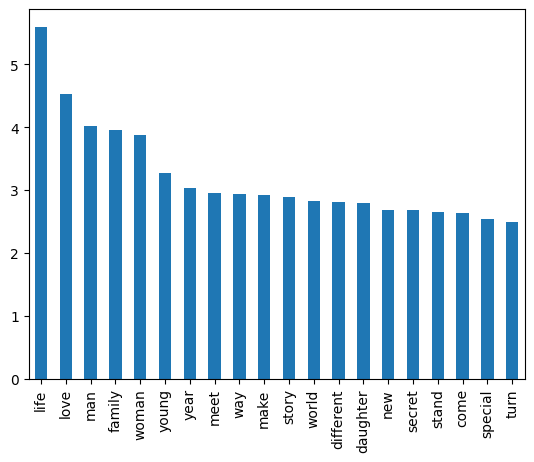

In [39]:
top_10_words_first_topic = sorted_df_first_topic.iloc[:20, :]
top_10_words_first_topic[0].plot.bar()

This output suggests that a common theme among the films in the dataset is family, life changes, and interpersonal relationships.